In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Load the data

In [2]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [3]:
y.shape, tx.shape

((10000,), (10000, 2))

### NB: throughout this laboratory the data has the following format: 
  * there are **N = 10000** data entries
  * **y** represents the column vector containing weight information -- that which we wish to predict/the output (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,)**.
  * **tx** represents the matrix $\tilde{X}$ formed by laterally concatenating a column vector of 1s to the column vector of height information -- the input data (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,2)**.

# 1. Computing the Cost Function
Fill in the `compute_loss` function below:

* The columns of $\tilde{X}$ are the input features of the dataset. The first columns of $\tilde{X}$ represent the intercept value. The second represents the values of height.
* The rows of $\tilde{X}$ represent the different samples
* the 1's column are the intercept coefficients.
* if we have 3 samples, the y would be aan array of size (3,) and $\tilde{X}$ would be an array of size (3, 2). $\tilde{X}_{3,2}$ would represent the height of the third individual.

## a)

Let $\mathcal{L} = MSE$

$\mathcal{L}(w) := \frac{1}{N} \sum_{n=1}^N (y_n - \tilde{X}w)^2$

$
\begin{aligned}
\mathcal{L}(w)  &= \frac{1}{2} ||\bold{y} - \bold{\tilde{X} w}||^2\\
        &= \frac{1}{2}\left( (\bold{y} - \bold{\tilde{X} w})^T (\bold{y} - \bold{\tilde{X} w}) \right)\\
        &= \frac{1}{2} \left( \bold{y}^T \bold{y} - 2 \bold{y}^T\bold{\tilde{X} w + w^T\bold{\tilde{X}^T \tilde{X}w}} \right)
\end{aligned}
$


In [4]:
def compute_loss(y, tx, w, MAE=False):
    """Calculate the loss using either MSE or MAE.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    # ***************************************************
    if MAE:
        loss = np.mean(np.abs(y - tx@w))
    else:
        loss = (1/2)*np.mean((y - tx@w)**2)
    # ***************************************************
    return loss

# 2. Grid Search

Fill in the function `grid_search()` below:

In [5]:
# from costs import *


def grid_search(y, tx, grid_w0, grid_w1):
    """Algorithm for grid search.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        grid_w0: numpy array of shape=(num_grid_pts_w0, ). A 1D array containing num_grid_pts_w0 values of parameter w0 to be tested in the grid search.
        grid_w1: numpy array of shape=(num_grid_pts_w1, ). A 1D array containing num_grid_pts_w1 values of parameter w1 to be tested in the grid search.

    Returns:
        losses: numpy array of shape=(num_grid_pts_w0, num_grid_pts_w1). A 2D array containing the loss value for each combination of w0 and w1
    """

    losses = np.zeros((len(grid_w0), len(grid_w1)))
    for i in range(len(grid_w0)):
        for j in range(len(grid_w1)):
            w0 = grid_w0[i]
            w1 = grid_w1[j]

            w = np.array([w0, w1])
            losses[i,j] = compute_loss(y, tx, w)
    return losses

Let us play with the grid search demo now!

Grid Search: loss*=18.793541019523236, w0*=71.42857142857142, w1*=15.306122448979579, execution time=0.081 seconds


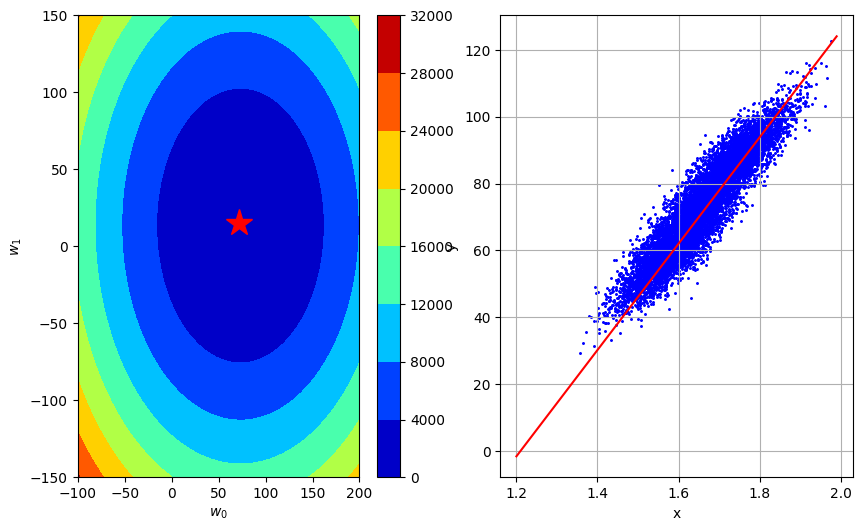

In [6]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=50)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print(
    "Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
        l=loss_star, w0=w0_star, w1=w1_star, t=execution_time
    )
)

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0, 6.0)
fig.savefig("grid_plot")  # Optional saving

## b)

* For a grid spacing of 50, the algorithm seems to fit the data pretty well, as it can be seen on the contour plot. The computed line also fits the data's trend well

* The result of the algorithm is a descent estimate, although it seems like it could better fit the data. That is first because we see on the contour plot that the solution found is not located at the center of the plot which seems to be the optimum. Also, it can be seen that the line doesn't perfectly fit the trend of the data.

* The results are similar for both MAE and MSE

## c)

* Having a finer grid will (most of the time) yield better accuracy.
* The grid-search algorithm searches on the 2D-grid, and computes the loss on each iteration. The computationnal cost of this routine is quadratic in the grid spacing times the computationnal cost of computing each loss
* Computation time is 22s for 1000 grid dimensions, 0.221s for 100 grid dimensions, 3ms for 10 grid dimensions. The quadratic time complexity is indeed verified.

# 3. Gradient Descent

Again, please fill in the functions `compute_gradient` below:

$\mathcal{L}(w) := \frac{1}{N} \left(\bold{y}^T \bold{y} - 2 \bold{y}^T\bold{\tilde{X} w + w^T\bold{\tilde{X}^T \tilde{X}w}} \right)$

$
\begin{aligned}
\nabla \mathcal{L}(w) &= \frac{1}{N} \left(- \tilde{X}^T y + \bold{\tilde{X}^T \tilde{X}w} \right) \\
                      &= \frac{1}{N} \tilde{X}^T(\tilde{X}w - y)
\end{aligned}
$

In [7]:
def compute_gradient(y, tx, w):
    """Computes the gradient at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        An numpy array of shape (2, ) (same shape as w), containing the gradient of the loss at w.
    """
    N = len(y)
    gradient = (1/N)*tx.T@(tx@w - y)
    return gradient

In [8]:
w = np.array([100, 20])
compute_gradient(y, tx, w)

array([26.706078  ,  6.52028757])

Please fill in the functions `gradient_descent` below:

In [9]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """The Gradient Descent (GD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of GD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of GD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        gradient = compute_gradient(y, tx, w)
        loss     = compute_loss(y, tx, w)
        
        w = w - gamma*gradient
        # store w and loss
        ws.append(w)
        losses.append(loss)
        print(
            "GD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [57]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.5

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/499: loss=2869.8351145358524, w0=37.03390292746317, w1=5.517447432994592
GD iter. 1/499: loss=766.906826210916, w0=55.55085439119476, w1=8.27617114949187
GD iter. 2/499: loss=241.1747541296816, w0=64.80933012306056, w1=9.655533007740496
GD iter. 3/499: loss=109.74173610937294, w0=69.43856798899347, w1=10.345213936864806
GD iter. 4/499: loss=76.88348160429574, w0=71.75318692195992, w1=10.69005440142696
GD iter. 5/499: loss=68.66891797802646, w0=72.91049638844315, w1=10.86247463370803
GD iter. 6/499: loss=66.61527707145913, w0=73.48915112168476, w1=10.948684749848566
GD iter. 7/499: loss=66.10186684481732, w0=73.77847848830557, w1=10.991789807918835
GD iter. 8/499: loss=65.97351428815686, w0=73.92314217161596, w1=11.013342336953967
GD iter. 9/499: loss=65.94142614899175, w0=73.99547401327116, w1=11.024118601471535
GD iter. 10/499: loss=65.93340411420047, w0=74.03163993409876, w1=11.029506733730319
GD iter. 11/499: loss=65.93139860550265, w0=74.04972289451257, w1=11.03220079985

In [58]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

In [12]:
gd_ws[5], gd_ws[-1]

(array([-560.475406  ,  596.01007704]), array([67.7624064 , 18.56401623]))

## c)

* The cost is being minimized
* The GD algo (with $\gamma=0.7$, $w_0=[0,0]$) is converging and the converging speed is fast as the step size of the algorithm is very low from iteration 5 and on (estimate at step 50 is almost equal to the one at step 5).
* Grid search had an loss of 18.8 with a grid step of 50. Gradient descent reaches a loss of 15.4 after 50 iterations. So GD reaches a better estimate.

## d)

* Experimenting with different step sizes - fixed initial position $w_0 = [0, 0]$:
    *  $\gamma = 0.001$: Convergence is very slow. Arround 5000 steps are at least needed to converge.
    *  $\gamma = 0.01$:  Convergence is faster (arround 500 steps needed to converge).
    *  $\gamma = 0.5$:   Convergence is faster (10 steps)
    *  $\gamma = 1$: Convergence in 2 steps.
    *  $\gamma = 2$: No convergence, the GD oscilates between two positions.
    *  $\gamma = 2.5$: Divergence, $\gamma$ is to big and the GD algorithms overshoots the solution.

* Experimenting with different initializations - fixed $\gamma = 0.1$:
    * $w_0 = [0,0]$         Convergence
    * $w_0 = [100, 10]$     Convergence
    * $w_0 = [-1000, 1000]$ Starting from an initial point that is far from the optimum yields in the need to take more steps to converge.


# 4. Stochastic gradient descent

First start by sampling a random datapoint $n \in \llbracket 1, N\rrbracket$ using a uniform distribution $\mathcal{U}\{1, 2, ..., N\}$

You can then compute the stochastic loss:

$\mathcal{L}_n = \frac{1}{2} ||\bold{y_n} - \bold{\tilde{X}_{n,:} w}||^2$


And the stochastic gradient:
$\nabla \mathcal{L}_n = \tilde{X}_{n,:}^T(\tilde{X}_{n,:}w - y_n)$

In [13]:
def compute_stoch_gradient(y, tx, w, batch_size):
    """Compute a stochastic gradient at w from just few examples n and their corresponding y_n labels.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the stochastic gradient of the loss at w.
    """

    mini_batch  = next(batch_iter(y, tx, batch_size=batch_size, num_batches=1, shuffle=True))
    y_batch     = mini_batch[0]
    tx_batch    = mini_batch[1]
    
    stoch_gradient = compute_gradient(y_batch, tx_batch, w)
    return stoch_gradient

def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic Gradient Descent algorithm (SGD).

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic gradient
        max_iters: a scalar denoting the total number of iterations of SGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    for n_iter in range(max_iters):
        gradient = compute_stoch_gradient(y, tx, w, batch_size)
        loss     = compute_loss(y, tx, w)
        
        w = w - gamma*gradient
        ws.append(w)
        losses.append(loss)

        print(
            "SGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

In [14]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD iter. 0/49: loss=2792.2367127591674, w0=6.01613306254515, w1=-4.6676378197163775
SGD iter. 1/49: loss=2443.1994908003003, w0=12.798524853464919, w1=-7.834726780179665
SGD iter. 2/49: loss=2072.3850854832453, w0=19.832827876481232, w1=-5.433437219028433
SGD iter. 3/49: loss=1623.2837953408714, w0=25.561313746213504, w1=-5.69746008545016
SGD iter. 4/49: loss=1338.4688062633822, w0=30.502264753100434, w1=-3.8158020162907125
SGD iter. 5/49: loss=1080.5162629941926, w0=36.622413020227526, w1=0.622659725704346
SGD iter. 6/49: loss=770.4375755574586, w0=39.43260542048051, w1=1.038089827816663
SGD iter. 7/49: loss=666.0772547389855, w0=44.56028604308474, w1=9.158828854921012
SGD iter. 8/49: loss=437.5318230378366, w0=48.12854771526472, w1=12.073189092075934
SGD iter. 9/49: loss=333.0230733242948, w0=50.17358721998107, w1=10.07675214429291
SGD iter. 10/49: loss=288.4508974576058, w0=52.13596349539764, w1=8.283548092691703
SGD iter. 11/49: loss=252.71555389068965, w0=54.82973128200016, w1=12

In [15]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses,
        sgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

The SGD procedure converges to the same optimum of the GD algorithm, but the path it takes is not optimal. As suchn it is seen in the contour plot that the SGD follows a path similar to GD but with an added noise to the steps.

# 5. Effect of Outliers and MAE Cost Function

In [16]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=True)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

Text(0, 0.5, 'weight')

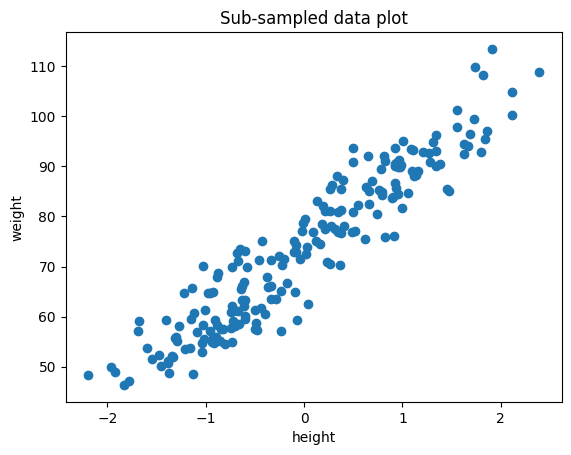

In [17]:
plt.scatter(tx[:, 1], y)
plt.title("Sub-sampled data plot")
plt.xlabel("height")
plt.ylabel("weight")

In [18]:
y.shape, tx.shape

((200,), (200, 2))

In [19]:
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()

gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)

end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=2829.2722244384163, w0=51.542590721811784, w1=10.132993413506085
GD iter. 1/49: loss=267.0500258779424, w0=67.00536793835532, w1=13.172891437557826
GD iter. 2/49: loss=36.45002800750035, w0=71.64420110331838, w1=14.084860844773324
GD iter. 3/49: loss=15.696028199160635, w0=73.03585105280729, w1=14.358451666937965
GD iter. 4/49: loss=13.828168216410077, w0=73.45334603765397, w1=14.440528913587356
GD iter. 5/49: loss=13.660060817962522, w0=73.57859453310797, w1=14.46515208758217
GD iter. 6/49: loss=13.644931152102242, w0=73.61616908174418, w1=14.472539039780616
GD iter. 7/49: loss=13.643569482174817, w0=73.62744144633503, w1=14.474755125440149
GD iter. 8/49: loss=13.643446931881353, w0=73.63082315571229, w1=14.47541995113801
GD iter. 9/49: loss=13.643435902354941, w0=73.63183766852546, w1=14.475619398847368
GD iter. 10/49: loss=13.64343490969756, w0=73.63214202236942, w1=14.475679233160175
GD iter. 11/49: loss=13.643434820358397, w0=73.6322333285226, w1=14.47569718345

In [20]:
# Time Visualization
from ipywidgets import IntSlider, interact
plt.close('all')

def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

In [21]:
print(f"optimal value for w: {list(gd_ws[-1])}")

optimal value for w: [73.63227245973111, 14.475704876437092]


## Adding outliers to the data

In [22]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=True, add_outlier=True)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

Text(0, 0.5, 'weight')

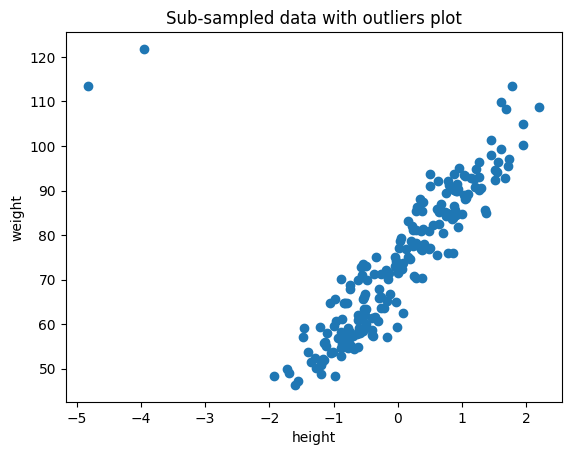

In [23]:
plt.scatter(tx[:, 1], y)
plt.title("Sub-sampled data with outliers plot")
plt.xlabel("height")
plt.ylabel("weight")

In [24]:
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()

gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)

end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=2869.8351145358524, w0=51.847464098448434, w1=7.724426406192428
GD iter. 1/49: loss=318.2821247015961, w0=67.40170332798299, w1=10.041754328050118
GD iter. 2/49: loss=88.6423556165127, w0=72.06797509684336, w1=10.736952704607411
GD iter. 3/49: loss=67.9747763988552, w0=73.46785662750146, w1=10.945512217574596
GD iter. 4/49: loss=66.11469426926604, w0=73.88782108669889, w1=11.00808007146475
GD iter. 5/49: loss=65.94728687760302, w0=74.01381042445813, w1=11.026850427631796
GD iter. 6/49: loss=65.93222021235334, w0=74.0516072257859, w1=11.03248153448191
GD iter. 7/49: loss=65.93086421248088, w0=74.06294626618423, w1=11.034170866536943
GD iter. 8/49: loss=65.93074217249236, w0=74.06634797830372, w1=11.034677666153454
GD iter. 9/49: loss=65.93073118889338, w0=74.06736849193958, w1=11.034829706038407
GD iter. 10/49: loss=65.93073020036948, w0=74.06767464603033, w1=11.034875318003893
GD iter. 11/49: loss=65.93073011140233, w0=74.06776649225755, w1=11.03488900159354
GD iter

In [25]:
# Time Visualization
from ipywidgets import IntSlider, interact
plt.close('all')

def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

The GD accounts for the outliers' values, and fits less well the regular value cloud.

# 6. Subgradient descent

## a)

The MAE cost function is the following:

$
\mathcal{L} (w) := \frac{1}{N} \sum_{n=1}^N |y_n - \tilde{X}_{n, :} w|
$

$
\mathcal{L} (w) = \frac{1}{N} ||y - \tilde{X}w||_1
$

$
\mathcal{L} (w) = \frac{1}{N} ||\cdot||_1 \circ \left(y - \tilde{X} \; \cdot \right) w
$

for a given vector $w$, the subgradient of the MAE cost function is computed as follows:

$
\begin{aligned}
\partial  \mathcal{L} (w)   &= \frac{1}{N} {\mathcal{J}_{y - \tilde{X}}^T \; \cdot}(w) \; \partial || \cdot ||_1(y - \tilde{X}w)\\
                            &= - \frac{1}{N} \tilde{X}^T \; \partial || \cdot ||_1(y - \tilde{X}w)
\end{aligned}
$

$
\partial || \cdot ||_1(y - \tilde{X}w) = \left \{ g \; : \; ||g||_{\infty} \leq 1, g^T \left( y - \tilde{X}w \right) = ||y - \tilde{X}w||_1 \right\}
$

lets choose $g \in \partial || \cdot ||_1(y - \tilde{X}w)$ as follows:

$
g_i = 
\begin{aligned}
    \begin{cases}
        (y - \tilde{X}w)_i && \text{if } (y - \tilde{X}w)_i \geq 0\\
        (y - \tilde{X}w)_i && \text{otherwise}
    \end{cases}
\end{aligned}
$

Thus one subgradient of MAE can be written as follows:

$- \frac{1}{N} \tilde{X}^T g$


In [49]:
def compute_subgradient_mae(y, tx, w):
    """Compute a subgradient of the MAE at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the subgradient of the MAE at w.
    """
    e = y - tx@w
    g = np.zeros_like(e)
    g[e>=0] = 1
    g[e<0]  = -1

    subgradient = -(1/len(y))*tx.T@g
    return subgradient

In [50]:
def subgradient_descent(y, tx, initial_w, max_iters, gamma):
    """The SubGradient Descent (SubGD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubGD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        loss = compute_loss(y, tx, w, MAE=True)
        subgradient = compute_subgradient_mae(y, tx, w)
        
        w = w - gamma*subgradient

        ws.append(w)
        losses.append(loss)
        print(
            "SubGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

In [51]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subgd_losses, subgd_ws = subgradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubGD: execution time={t:.3f} seconds".format(t=exection_time))

SubGD iter. 0/499: loss=74.06780585492638, w0=0.7000000000000004, w1=7.237266341775239e-16
SubGD iter. 1/499: loss=73.36780585492637, w0=1.4000000000000008, w1=1.4474532683550478e-15
SubGD iter. 2/499: loss=72.66780585492637, w0=2.1000000000000014, w1=2.1711799025325716e-15
SubGD iter. 3/499: loss=71.96780585492637, w0=2.8000000000000016, w1=2.8949065367100956e-15
SubGD iter. 4/499: loss=71.26780585492638, w0=3.5000000000000018, w1=3.6186331708876196e-15
SubGD iter. 5/499: loss=70.56780585492638, w0=4.200000000000002, w1=4.342359805065143e-15
SubGD iter. 6/499: loss=69.86780585492637, w0=4.900000000000002, w1=5.066086439242667e-15
SubGD iter. 7/499: loss=69.16780585492637, w0=5.600000000000002, w1=5.7898130734201904e-15
SubGD iter. 8/499: loss=68.46780585492637, w0=6.3000000000000025, w1=6.513539707597714e-15
SubGD iter. 9/499: loss=67.76780585492638, w0=7.000000000000003, w1=7.237266341775238e-15
SubGD iter. 10/499: loss=67.06780585492638, w0=7.700000000000003, w1=7.960992975952761e-1

In [52]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subgd_losses,
        subgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

# Stochastic Subgradient Descent

**NB** for the computation of the subgradient you can reuse the `compute_subgradient` method that you implemented above, just making sure that you pass in a minibatch as opposed to the full data.

In [59]:
def compute_stochastic_subgradient_mae(y, tx, w):
    mini_batch  = next(batch_iter(y, tx, batch_size=batch_size, num_batches=1, shuffle=True))
    y_batch     = mini_batch[0]
    tx_batch    = mini_batch[1]
    
    stoch_subgradient = compute_subgradient_mae(y_batch, tx_batch, w)
    return stoch_subgradient

def stochastic_subgradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic SubGradient Descent algorithm (SubSGD).

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic subgradient
        max_iters: a scalar denoting the total number of iterations of SubSGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubSGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubSGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    for n_iter in range(max_iters):
        stochastic_subgradient = compute_stochastic_subgradient_mae(y, tx, w)
        w = w - stochastic_subgradient
        loss = compute_loss(y, tx, w, MAE=True)

        ws.append(w)
        losses.append(loss)


        print(
            "SubSGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

In [60]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subsgd_losses, subsgd_ws = stochastic_subgradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubSGD: execution time={t:.3f} seconds".format(t=exection_time))

SubSGD iter. 0/499: loss=73.06780585492638, w0=1.0, w1=0.16260046687758953
SubSGD iter. 1/499: loss=72.06780585492638, w0=2.0, w1=2.113128256397034
SubSGD iter. 2/499: loss=71.06780585492636, w0=3.0, w1=3.1788220472361726
SubSGD iter. 3/499: loss=70.06780585492638, w0=4.0, w1=2.790993215832488
SubSGD iter. 4/499: loss=69.06780585492638, w0=5.0, w1=2.8655079951606464
SubSGD iter. 5/499: loss=68.06780585492638, w0=6.0, w1=4.3118484778269615
SubSGD iter. 6/499: loss=67.06780585492636, w0=7.0, w1=4.691110909575862
SubSGD iter. 7/499: loss=66.06780585492638, w0=8.0, w1=0.7335399140201626
SubSGD iter. 8/499: loss=65.06780585492638, w0=9.0, w1=2.2944320773427265
SubSGD iter. 9/499: loss=64.06780585492636, w0=10.0, w1=3.158049371420097
SubSGD iter. 10/499: loss=63.06780585492636, w0=11.0, w1=1.9637081467446458
SubSGD iter. 11/499: loss=62.067805854926384, w0=12.0, w1=0.2722764318962294
SubSGD iter. 12/499: loss=61.067805854926384, w0=13.0, w1=-0.20824207906959452
SubSGD iter. 13/499: loss=60.0

In [61]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subsgd_losses,
        subsgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subsgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>